## bitmapで与えられたMaskデータをPolygonに変換できないか試してみる

In [34]:
import geopandas as gpd
from geopandas import GeoSeries
import sunpy.map

In [86]:
#元データ(Mask)
mask_path = "../samples/sun/Mharp/hmi.Mharp_720s.1.20100501_000000_TAI.bitmap.fits"
mask_map = sunpy.map.Map(mask_path)
mask_map

ValueError: Could not determine celestial frame corresponding to the specified WCS object

## 各キーのデータの詳細
(http://sun.stanford.edu/~baldner/test/Series/hmi.Mharp_720s.txt)

In [36]:
mask_map.meta["lat_fwt"]

23.815041

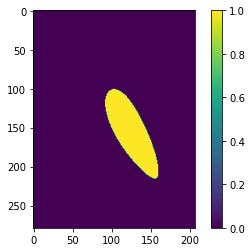

In [51]:

import matplotlib.pyplot as plt
import numpy as np
plt.figure(1)
ax = plt.subplot(1,1,1)
# ax.set_xlim([0, 300])
# ax.set_ylim([0,len(binaried_mask_map.data)]) #y軸を反転
binaried_mask_map=np.where((mask_map.data==33)|(mask_map.data==34),1,0)
im = ax.imshow(binaried_mask_map) #climの範囲を変えればダイナミックレンジを変更できる
# im = ax.imshow(np.where(((mask_map.data==34)),1,0))
#カラーバーのプロット
plt.colorbar(im)
# plt.figure(1).suptitle("")#画像の上側にタイトル
# plt.figure(1).savefig("保存するときの名前")#保存
plt.show()


In [5]:
type(binaried_mask_map)

NameError: name 'binaried_mask_map' is not defined

## GDALモジュールを使ってみる
GDALモジュールを使用するとラスターデータ(Bitmap？)からPolygonデータを生成できるみたいなので使えるかどうか試してみる  
[参考:Python3×地理空間データ　GDAL Python API](https://ujicya.jp/blog-mapping/python-gdal-api/)  
[参考:PythonGDAL/OGR document:Raster Layers](http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#polygonize-a-raster-band)

### numpy配列からPolygonデータへの加工
gdal_array.OpenArray関数はnumpy配列をデータセットとして変形可能なGDALデータセット形式に変換する。
✖︎その後、Polygonへ

In [6]:
# ✖️
# from osgeo import gdal_array,ogr,gdal

# raster_map = gdal_array.OpenArray(binaried_mask_map)
# raster_map
# srcband = raster_map.GetRasterBand(1)
# dst_layername = "POLYGONIZED_MASK"
# drv = ogr.GetDriverByName("ESRI Shapefile")
# dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
# dst_layer = dst_ds.CreateLayer(dst_layername, srs = None )

# gdal.Polygonize(srcband, None, dst_layer, -1, [], callback=None )

うまくいかなかったので別の手を試してみる。  
Rasterioというモジュールが使えるかもしれない  
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons  
https://rasterio.readthedocs.io/en/latest/index.html


Polygonをうまく書き出せるか試す
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Polygon.html


In [43]:
import rasterio
from rasterio.features import shapes
mask = None

mask_polygon, value = shapes(binaried_mask_map.astype("int16"), mask=mask)
# x = [mask_polygon[0]["coordinates"][0][i][0] for i in range(len(mask_polygon[0]["coordinates"][0]))]
# y = [mask_polygon[0]["coordinates"][0][i][1] for i in range(len(mask_polygon[0]["coordinates"][0]))]
# # type(mask_polygon[0]["coordinates"][0])



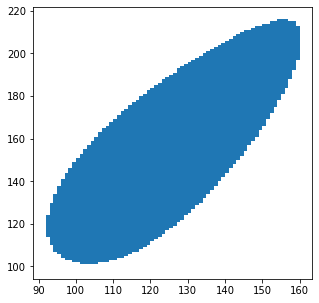

In [44]:
# matplotlib.pyplotをインポート
import matplotlib.pyplot as plt
# matplotlib.patchesをインポート
import matplotlib.patches as pat
# Figureを作成
fig = plt.figure(figsize=(5, 5))
# FigureにAxes(サブプロット)を追加
ax = fig.add_subplot(111)
ax.plot(100,100)
p = pat.Polygon(xy = mask_polygon[0]["coordinates"][0])
ax.add_patch(p)


In [9]:
# MaskPolygonの中身表示
# mask_polygon[0]["coordinates"][0]

## MaskデータのPolygon化について
上記の方法でBitmapの中身をPolygonに変換することができた。
これを自動化して、データセットと合体するところまで行けば学習に入れると思う

## データセットとの結合について
３次元の光球データと視野方向のデータとのそれぞれでデータセットにOverrayする必要があるのでそれぞれについてどのようにデータを与えるか試す
## 実装のアイディア
1. そもそもの光球データの座標系を確認
2. それぞれのMaskデータはおそらく原点が各ARの左下端になっているので、Maskを置く座標を変換する
3. 同時間帯にあるMaskを全てOverray仕切ったら出力
4. その画像とJSOC提供のデータとの差異を確認
5. 良さそうならデータを全体で作る(COCO Formatに変換)


In [10]:
## 3Dデータ
hmi_region_path = "../samples/sun/HMI_REGION/hmi.M_45s.20100501_000000_TAI.2.magnetogram.fits"
hmi_region_map = sunpy.map.Map(hmi_region_path)
hmi_region_map

NameError: name 'sunpy' is not defined

## Maskの座標系の変換
全球データはHelioprojectiveの座標系→太陽の球面状の座標(秒角表記)  
MaskデータはPixel単位での表記なのでそのままはOverrayできない  
→→Mask側を変換してうまくOverrayする方法を考えてみる  
参考になりそうなReference  
https://docs.sunpy.org/en/0.7/code_ref/coordinates.html#module-sunpy.coordinates.transformations  
https://docs.sunpy.org/en/v0.8.2/code_ref/map.html?highlight=sunpy%20map#module-sunpy.map



In [11]:
import astropy.units as u
mask_map.pixel_to_world

NameError: name 'mask_map' is not defined

In [12]:
# mask_map_world関数は引数としてAstropy.Quantity✖︎2軸分を受け取り、SkyCoordオブジェクトを返す
import sunpy.coordinates
from astropy.wcs.utils import wcs_to_celestial_frame
# mask_map_world = mask_map.pixel_to_world
# mask_map_world(x=100*u.pix,y=100*u.pix)
mask_map.wcs

NameError: name 'mask_map' is not defined

In [13]:
from astropy.wcs.utils import wcs_to_celestial_frame
import sunpy.coordinates
import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
amap = sunpy.map.Map(AIA_171_IMAGE)
wcs_to_celestial_frame(amap.wcs)

<Helioprojective Frame (obstime=2011-06-07T06:33:02.770, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>)>

In [45]:
## もしかして座標系のデータはいらない・・？→データもMaskもピクセル座標系なのでそのままOverrayしてしまって軸だけ後で変更・・？
plt.figure(1)
ax = plt.subplot(1,1,1)
ax.set_ylim([0,len(hmi_region_map.data)])
ax.imshow(hmi_region_map.data)
# ax.imshow(mask_map.data)
plt.show()

NameError: name 'hmi_region_map' is not defined

多分AR領域と全休の比率はあってるけど座標系はめちゃくちゃでかつQuietの部分も反映されてしまっているのでそこを直したい  
→Quietの部分に関しては多分データセットをChaincodeで作成するので問題にはならない？

## Mask領域の回転について
Maskと全球データの座標系・位置を揃えるために全体的に修正を行う。  
1. Maskデータを4k,4kで0埋め  
2. 画像の中心を基準にCrota2分回転  
3. Mask画像をOverray

In [56]:
# 1.Maskデータを4k4kで0埋め
mask_center = np.array([mask_map.reference_pixel[0].value,mask_map.reference_pixel[1].value])
mask_ll = mask_center-(mask_map.meta["naxis1"]//2,mask_map.meta["naxis2"]//2)
mask_ur = mask_center+(mask_map.meta["naxis1"]//2,mask_map.meta["naxis2"]//2)
full_disk_coord = 4096
pad_width = np.array([[full_disk_coord-mask_ur[1],mask_ll[1]],[mask_ll[0],full_disk_coord-mask_ur[0]]])
padded_map = np.pad(np.flipud(binaried_mask_map),np.array(pad_width,dtype="int"),"constant")
mask_center,mask_ll,mask_ur

(array([3599., 1105.]), array([3496.,  966.]), array([3702., 1244.]))

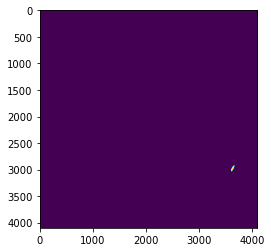

In [57]:
plt.figure(1)
ax = plt.subplot(1,1,1)
# ax.set_ylim([0,len(padded_map)])
ax.imshow(padded_map)
# ax.imshow(mask_map.data)
plt.show()

## 先生に質問したいこと
- 回転の方向について→時計Or反時計Orそれ以外  
- 回転に使用するモジュールについて  
→PIL等のPython通常の画像処理モジュールで大丈夫？  
もしくは太陽に特化した方法が必要？  
https://ehsteve-sunpy.readthedocs.io/en/latest/generated/gallery/gallery/map_rotation.html  
→Map.rotateは普通に使っても良さそう。  
同じ時間の全球のFitsファイル持ってきてCoordinate Pixelを参照してそれを参考に時計回りに約180度回転

In [17]:
# import pandas as pd
# import datetime
# import glob
# columns = ["time","referencex","referencey","chaincode"]
# coordinate_df = pd.DataFrame(columns=columns)
# START_TIME = datetime.datetime(2010,5,1,0,0,0)
# END_TIME = datetime.datetime(2011,1,1,0,0,0)
# time =START_TIME
# while time != END_TIME:
#     line = pd.Series([time,0,0,0],index=coordinate_df.columns)
#     coordinate_df = coordinate_df.append(line,ignore_index =True)
#     time= time+datetime.timedelta(hours=1)
# hmi_region_path = "/media/akito/Data/HMI_REGION/2010/*.fits"
# hmi_region_files= sorted(glob.glob(hmi_region_path))
# hmi_region_files[0]
# for hmi_region_file in hmi_region_files:
#     hmi_region_map = sunpy.map.Map(hmi_region_file)
#     t_rec = datetime.datetime.strptime(hmi_region_map.meta["t_rec"],"%Y.%m.%d_%H:%M:%S_TAI")
#     coordinate_df.loc[coordinate_df["time"]==t_rec,"referencex"]= hmi_region_map.reference_pixel[0].value
#     coordinate_df.loc[coordinate_df["time"]==t_rec,"referencey"]= hmi_region_map.reference_pixel[1].value

# hmi_me_map.meta["t_rec"],t_rec

In [18]:
# coordinate_df.to_csv("2010.csv")

In [19]:
# [time for time,refx in zip(coordinate_df["time"],coordinate_df["referencex"]) if refx==0 ][0]

In [20]:
# Sunpyのモジュールを使用して回転させてみる→大丈夫そう
hmi_region_map_rotated = hmi_region_map.rotate(angle = -1*float(hmi_region_map.meta["crota2"])*u.deg)
hmi_region_map_rotated.peek(draw_limb=True,draw_grid=True)

NameError: name 'hmi_region_map' is not defined

In [73]:
# Maskの回転
import cv2
height = full_disk_coord
width = full_disk_coord
center = (mask_map.meta["imcrpix1"],mask_map.meta["imcrpix2"])
angle = -1* mask_map.meta["crota2"]
scale = 1.0
trans = cv2.getRotationMatrix2D(center,angle,scale)
image2 = cv2.warpAffine(padded_map.astype("int16"),trans,(width,height))
image2 = np.flipud(image2)

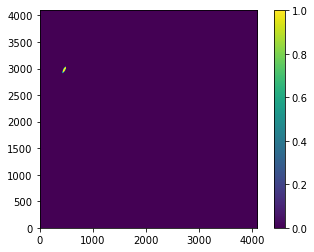

In [74]:
plt.figure(1)
ax = plt.subplot(1,1,1)
ax.set_ylim([0,len(image2)])
im =ax.imshow(image2)
plt.colorbar(im)
# ax.imshow(mask_map.data)
plt.show()

In [75]:
# もともとの画像サイズが大きすぎてうまくPolygon化できないので切り出してからPolygon化をしてみる
from PIL import Image
left = int(full_disk_coord-mask_ur[0])
right = int(full_disk_coord-mask_ll[0])
lower = int(full_disk_coord-mask_ur[1])
upper = int(full_disk_coord-mask_ll[1])
rotated_ar_map = image2[lower:upper,left:right]
left,right,lower,upper

(394, 600, 2852, 3130)

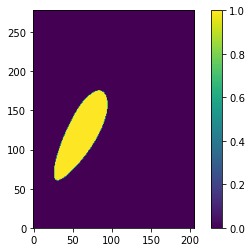

In [79]:
plt.figure(1)
ax = plt.subplot(1,1,1)
ax.set_ylim([0,upper-lower])
im =ax.imshow(rotated_ar_map)
plt.colorbar(im)
# ax.imshow(mask_map.data)
plt.show()

In [80]:

import rasterio
from rasterio.features import shapes
mask = None
# rotated_mask_map=np.where((image2!=0),1,0)
rotated_mask,value = shapes(rotated_ar_map.astype("int16"),mask=None,connectivity = 8)
# binaried_mask_map.shape


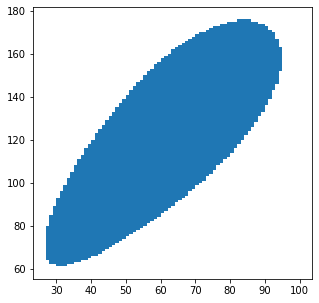

In [81]:
# matplotlib.pyplotをインポート
import matplotlib.pyplot as plt
# matplotlib.patchesをインポート
import matplotlib.patches as pat
# Figureを作成
fig = plt.figure(figsize=(5, 5))
# FigureにAxes(サブプロット)を追加
ax = fig.add_subplot(111)
ax.plot(100,100)
p = pat.Polygon(xy = rotated_mask[0]["coordinates"][0])
ax.add_patch(p)

In [82]:
rotated_mask_fixed =[]
for coord in rotated_mask[0]["coordinates"][0]:
    x = coord[0]+left
    y = coord[1]+lower
    rotated_mask_fixed.append((x,y))
rotated_mask_fixed

[(424.0, 2913.0),
 (424.0, 2914.0),
 (423.0, 2914.0),
 (422.0, 2914.0),
 (422.0, 2916.0),
 (421.0, 2916.0),
 (421.0, 2932.0),
 (422.0, 2932.0),
 (422.0, 2937.0),
 (423.0, 2937.0),
 (423.0, 2941.0),
 (424.0, 2941.0),
 (424.0, 2945.0),
 (425.0, 2945.0),
 (425.0, 2948.0),
 (426.0, 2948.0),
 (426.0, 2951.0),
 (427.0, 2951.0),
 (427.0, 2954.0),
 (428.0, 2954.0),
 (428.0, 2957.0),
 (429.0, 2957.0),
 (429.0, 2960.0),
 (430.0, 2960.0),
 (430.0, 2963.0),
 (431.0, 2963.0),
 (431.0, 2965.0),
 (432.0, 2965.0),
 (432.0, 2968.0),
 (433.0, 2968.0),
 (433.0, 2970.0),
 (434.0, 2970.0),
 (434.0, 2972.0),
 (435.0, 2972.0),
 (435.0, 2975.0),
 (436.0, 2975.0),
 (436.0, 2977.0),
 (437.0, 2977.0),
 (437.0, 2979.0),
 (438.0, 2979.0),
 (438.0, 2981.0),
 (439.0, 2981.0),
 (439.0, 2983.0),
 (440.0, 2983.0),
 (440.0, 2985.0),
 (441.0, 2985.0),
 (441.0, 2987.0),
 (442.0, 2987.0),
 (442.0, 2989.0),
 (443.0, 2989.0),
 (443.0, 2991.0),
 (444.0, 2991.0),
 (444.0, 2993.0),
 (445.0, 2993.0),
 (445.0, 2995.0),
 (446.0, 2

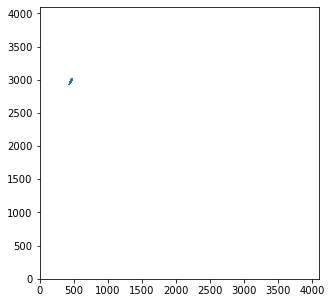

In [85]:
# matplotlib.pyplotをインポート
import matplotlib.pyplot as plt
# matplotlib.patchesをインポート
import matplotlib.patches as pat
# Figureを作成
fig = plt.figure(figsize=(5, 5))
# FigureにAxes(サブプロット)を追加
ax = fig.add_subplot(111)
ax.set_xlim([0,full_disk_coord])
ax.set_ylim([0,full_disk_coord])
p = pat.Polygon(xy = rotated_mask_fixed)
ax.add_patch(p)

In [84]:
import pickle
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as pat
def show_polygon(polygon):
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.xlim(0,4000)
    ax.set_ylim([4000,0]); #y軸を反転
    p = pat.Polygon(polygon)
    ax.add_patch(p)
    plt.show()
def show_polygons(polygons):
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.xlim(0,4000)
    plt.ylim(0,4000)
    print(polygons[4][0])
    for polygon in polygons:
        p = pat.Polygon(polygon[0])
        print(polygon)
        ax.add_patch(p)
    plt.show()
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data
# coord_series = pickle_load("/home/akito/Documents/Documents/Predict_Solar_Flare_Mrcnn/src_dataset/Coord_series.pickle")
# show_polygon(coord_series["2010-05-01 00:00:00"][0][0])

In [30]:
import pickle
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as pat
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data
coord_series = pickle_load("/home/akito/Documents/Documents/Predict_Solar_Flare_Mrcnn/src_dataset/Coord_series.pickle")
coord_series["2010-05-01 00:00:00"]

FileNotFoundError: [Errno 2] No such file or directory: '/home/akito/Documents/Documents/Predict_Solar_Flare_Mrcnn/src_dataset/Coord_series.pickle'

In [31]:
import sunpy.map
map = sunpy.map.Map("/media/akito/Data/HMI_REGION/2010/201005/hmi.M_45s.20100501_000000_TAI.2.magnetogram.fits")
def show_polygon_map(polygon,map):
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.xlim(0,4000)
    ax.set_ylim([4000,0]) #y軸を反転
    ax.imshow(map)
    p = pat.Polygon(polygon)
    ax.add_patch(p)
    plt.show()
coord_series = pickle_load("/home/akito/Documents/Documents/Predict_Solar_Flare_Mrcnn/src_dataset/Coord_series.pickle")
show_polygon_map(coord_series["2010-05-01 00:00:00"][0],map.data)

ValueError: File not found or invalid input

In [32]:
map_path = sunpy.map.Map("/media/akito/Data/HMI_REGION/2010/201005/hmi.M_45s.20100501_000000_TAI.2.magnetogram.fits")
def show_polygons(polygons):
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.xlim(0,4000)
    ax.set_ylim([4000,0])
    ax.imshow(map.data)
    for polygon in polygons:
        p = pat.Polygon(polygon)
        ax.add_patch(p)
    plt.show()
coord_series = pickle_load("/home/akito/Documents/Documents/Predict_Solar_Flare_Mrcnn/src_dataset/Coord_series.pickle")
show_polygons(coord_series["2010-05-06 00:00:00"])

ValueError: File not found or invalid input